In [1]:
import itertools
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

import json
import functools
from glob import glob
import os

from importlib import reload

import utils
import persim

import tifffile as tf
from KDEpy import FFTKDE
from scipy import ndimage,stats,spatial
from sklearn import decomposition, preprocessing, tree, metrics

In [2]:
nuclei_mask_cutoff = 1
seed = 42
ndims = 3
fs = 12
PP = 6
dpi = 96
minlife = 0.0
rng = np.random.default_rng(seed)
permmethod = stats.PermutationMethod(n_resamples=999, random_state=rng)

Cmap='plasma'
pxs = 75
pxbar = np.s_[-25:-5, 5:5 + pxs]
s = 50
alphaNmin = 0.1
alphaNmax = 10

wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#f0e442', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#e0e0e0', '#000000']
cmap = ['Blues_r', 'RdPu_r', 'Greens_r', 'BuPu_r', 'Oranges_r', 'Wistia', 'YlOrBr_r', 'gray', 'gist_gray']
box_params = {'widths':0.75, 'patch_artist':True, 'medianprops':{'lw':3, 'color':'red'} }
#figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'
sample = 'D2'

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/' + sample + os.sep
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep + sample + os.sep
geosrc =  '..' + os.sep + 'geometry' + os.sep + sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
metaecc['eccentricity'] = metaecc['eccentricity'].max() - metaecc['eccentricity'].values

metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')
cell_nuc.loc[cell_nuc['n_bot'] == 1, 'n_bot'] = 0
cell_nuc.loc[cell_nuc['n_top'] == 61, 'n_top'] = 65

transcriptomes = np.asarray(list(metatrans['gene']))
metatrans = metatrans.set_index('gene')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
Cs = dict(zip(Genes, ['#56b4e9','#cc79a7']))
Ms = dict(zip(Genes, ['D','s']))
Ps = dict(zip(Genes, ['Blues_r','PuRd_r']))
invGenes = dict(zip(Genes, range(len(Genes))))
invCells = dict(zip(Cells, range(len(Cells))))
transfocus = transcell.loc[transcriptomes[Genes], Cells.astype(str)]

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')
wcoords = np.asarray(np.nonzero(~wall))
foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cellular_cmap = ListedColormap(foo)

wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
    translocs[i]['cidx'] = label[ translocs[i]['Y'], translocs[i]['X'] ]
    translocs[i]['nidx'] =  lnuc[ translocs[i]['Y'], translocs[i]['X'] ]

tlocs = pd.concat(translocs)


Detected 2937 cells
Detected 1365 nuclei


# Bring in persistence images to the party

In [3]:
level = 'sub'
normtype = 'both'
stepsize = 3
bw = 25
SCALE = 32

zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)

dsrc = isrc + 'G{}_{}level_{}_step{}_bw{}'.format(len(Genes), level, normtype, stepsize, bw) + os.sep
ratios = utils.normalize_counts(transfocus, normtype)

jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]
gsrc = '../{}level/'.format(level) + sample + os.sep
for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

orig_diags = [ utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True) for i in range(len(jsonfiles))]
orig_diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)

kde_max = np.zeros(ratios.size)
for i in range(len(orig_diags)):
    for j in range(len(orig_diags[i])):
        if len(orig_diags[i][j][focus_dim]) > 0:
            kde_max[i*len(orig_diags[i]) + j] = np.max(orig_diags[i][j][focus_dim])

kmax = np.sort(kde_max)[-20]

Initial number of life-birth pairs	: 64671

No. of diagrams s.t. H_k had the most persistent component
H_0:	26 [ 1.4% ]
H_1:	142 [ 7.7% ]
H_2:	1668 [ 90.8% ]

Will focus just on dimension k = 2



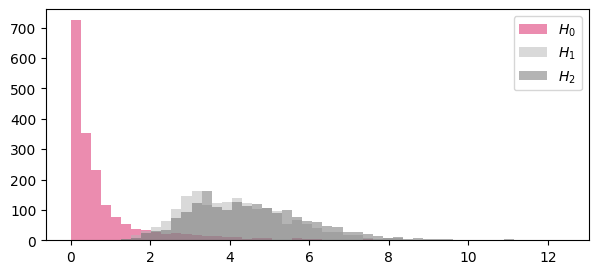

In [12]:
maxl = np.vstack(maxlife)
bins = np.linspace(0, maxl.max(), 50)

fig, ax = plt.subplots(1,1, figsize=(7,3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0
for i in range(maxl.shape[1]):
    ax[j].hist(maxl[:,i], bins=bins, color=wong[i], alpha=0.5, label='$H_{{{}}}$'.format(i))
ax[j].legend();

# Loadings

In [15]:
reload(utils)
cidx = 169

filename = geosrc + 'peripherality_c{:06d}.csv'.format(cidx)
peripherality = pd.read_csv(filename)

cell, cextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, pxbar=True, PP=6)
s_ = (np.s_[cextent[2]:cextent[3]], np.s_[cextent[0]:cextent[1]])
edt = ndimage.distance_transform_edt(label[s_] == cidx)
axes, grid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, cell, label[s_], cextent, zmax, stepsize, cell_nuc)

outs = ~outside_walls.copy().reshape( list(map(len, axes))[::-1], order='F')
alpha = min([1.5*int(4e6/cell.size)/100, 0.8])

hcoords, hkde = [ [] for _ in range(2) ]

for gidx in Genes:

    coords = translocs[gidx].loc[ translocs[gidx]['cidx'] == cidx , ['X', 'Y', 'Z'] ].values.T
    
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T).evaluate(grid)
    kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(coords)))
    kde[outside_walls] = 0
    
    kde = kde/(np.sum(kde)*(stepsize**len(coords)))
    kde = kde.reshape( list(map(len, axes))[::-1], order='F')
       
    hkde.append( kde.copy() * ratios[invGenes[gidx]][invCells[cidx]] )
    hcoords.append(coords)

loc_kmax = max(map(np.max, hkde))

In [52]:
KBINS_NO = 27

kbins = np.linspace(0, np.max(edt), KBINS_NO)
cellhist = np.digitize(edt, kbins, right=True)
hsummary = [None for _ in range(len(Genes))]
hhist = [cellhist.copy() for _ in range(len(Genes))]

i = 0
for i in range(len(Genes)):
    gidx = Genes[i]
    hsummary[i] = ratios[invGenes[gidx] , invCells[cidx]] * peripherality['mean_{}_-_{}'.format(bw, transcriptomes[gidx])].values / kmax
    temp = (1e5*np.hstack(([0], hsummary[i]))).astype(int)
    with np.nditer(hhist[i], flags=['external_loop'], op_flags=['readwrite']) as it:
        for x in it:
            x[...] = temp[x]
loc_smax = 1e5*max([ max(map(np.max, hsummary[i])) for i in range(len(hsummary)) ])

# ys = ratios[invGenes[gidx] , invCells[cidx]] * peripherality['mean_{}_-_{}'.format(bw, transcriptomes[gidx])].values / kmax

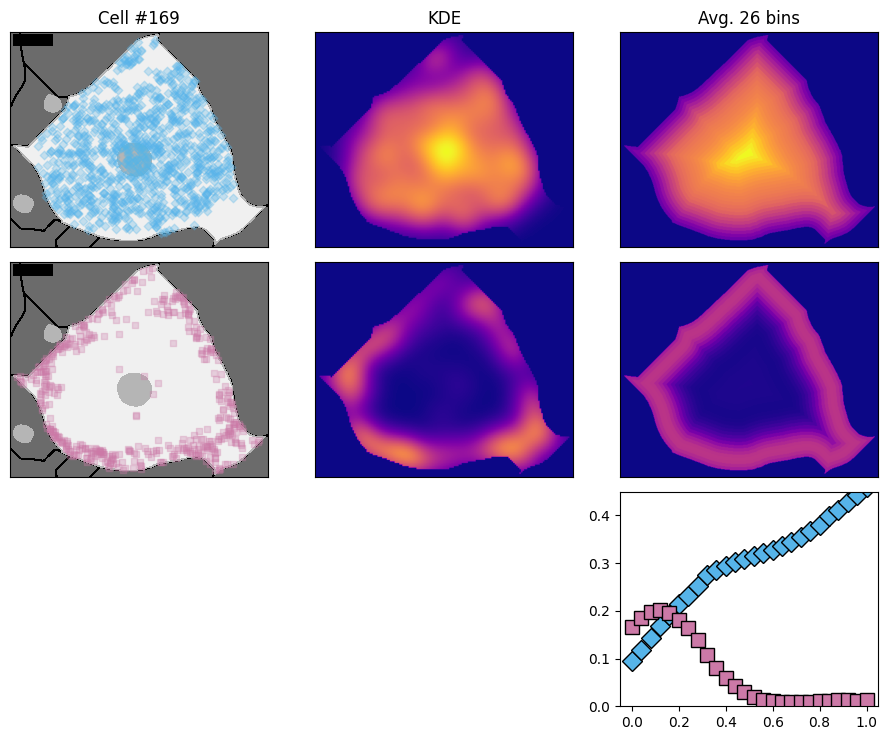

In [61]:
fig, ax = plt.subplots(3, 2+1, figsize=(6+3*1, 7.5), sharex=False, sharey=False)

for i in range(len(Genes)):
    j = 0
    ax[i,j].imshow(cell+1, cmap=cellular_cmap, origin='lower', extent=cextent, vmin=0, vmax=nnuc+2);
    ax[i,j].scatter(*(hcoords[i][:2]), color=Cs[Genes[i]], marker=Ms[Genes[i]], alpha=alpha, s=int(4e6/cell.size))
    ax[i,j].set_facecolor(wong[2])

    j += 1
    ax[i,j].imshow(np.max(hkde[i], axis=0), origin='lower', cmap=Cmap, vmin=0, vmax=loc_kmax, zorder=1)
    ax[i,j].set_facecolor( mpl.colormaps[ Cmap ](0) )

    j += 1
    ax[i, j].imshow(hhist[i], origin='lower', cmap=Cmap, vmin=0, vmax=loc_smax)
    ax[i, j].set_facecolor( mpl.colormaps[ Cmap ](0) )

ax[0,0].set_title('Cell #{}'.format(cidx), fontsize=fs)
ax[0,1].set_title('KDE', fontsize=fs)

i = 0
ax[0,2+i].set_title('Avg. {} bins'.format(KBINS_NO-1), fontsize=fs)
for j in range(len(Genes)):
    ax[2,2].plot(np.linspace(0,1,KBINS_NO-1), hsummary[j],
                   color=Cs[Genes[j]], lw=3, marker=Ms[Genes[j]], ms=10, mec='k', mew=1)
    ax[2,2].set_ylim(0, 0.45)

for ix in [(2,0), (2,1)]:
    fig.delaxes(ax[ix])
    

for a in ax.ravel()[:(4 + 2*1)]:
    a.set_aspect('equal','datalim')
    a.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.tight_layout()
#plt.savefig('cell{}_periphery_analyses.png'.format(cidx), dpi=dpi, bbox_inches='tight', format='png')

#print(hsummary[0][0], '--', hsummary[1][0], sep='\n')

In [62]:
hsummary

[array([0.09488701, 0.11841207, 0.1424231 , 0.16771778, 0.19033482,
        0.21408581, 0.2317039 , 0.25132543, 0.27488183, 0.28475972,
        0.29486587, 0.30232306, 0.30941516, 0.3159996 , 0.32187876,
        0.32860625, 0.33601732, 0.34536046, 0.35525869, 0.36768407,
        0.38010408, 0.3980949 , 0.41095206, 0.42813321, 0.44369728,
        0.46042771]),
 array([0.16633325, 0.18462728, 0.19807309, 0.20103555, 0.19614209,
        0.18057275, 0.16327141, 0.13800038, 0.10752578, 0.08067071,
        0.05869834, 0.04174553, 0.02899617, 0.02009246, 0.01411869,
        0.0106293 , 0.0088971 , 0.00854302, 0.00883506, 0.00971938,
        0.01052564, 0.01187506, 0.01232479, 0.0122389 , 0.01197294,
        0.01262525])]

In [65]:
n_seg = 3
xs = np.linspace(0,1, len(peripherality))

gidx = 85
ys = ratios[invGenes[gidx] , invCells[cidx]] * peripherality['mean_{}_-_{}'.format(bw, transcriptomes[gidx])].values / kmax

dys = np.gradient(ys, xs)
rgr = tree.DecisionTreeRegressor(max_leaf_nodes=n_seg)
rgr.fit(xs.reshape(-1, 1), dys.reshape(-1, 1))
dys_dt = rgr.predict(xs.reshape(-1, 1)).flatten()
uq, idxs = np.unique(dys_dt, return_inverse=True)
css = ndimage.find_objects(idxs+1)

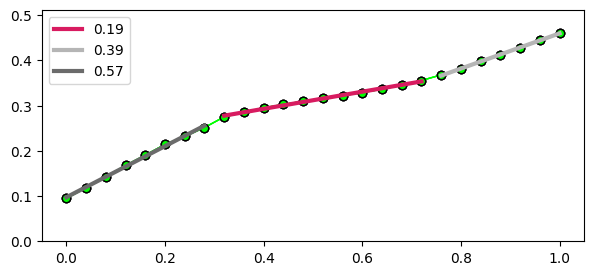

In [66]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

fig, ax = plt.subplots(1,1, figsize=(7,3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

ys_sl = np.ones(len(xs)) * np.nan
for i in range(len(uq)):

    linregress = stats.linregress(xs[css[i]], ys[css[i] ])
    ys_sl[ css[i] ] = linregress.slope*xs[css[i] ] + linregress.intercept
    
    ax[j].plot(xs, ys, lw=1, marker='o', c='lime', zorder=1, mec='k')
    
    ax[j].plot([xs[css[i]][0], xs[css[i]][-1]], [ys_sl[css[i]][0], ys_sl[css[i]][-1]], 
             color=wong[i], zorder=2, lw=3, label='{:.2f}'.format(linregress.slope))

ax[j].set_ylim(0, ys.max()+0.05)
ax[j].legend();

In [56]:
i,j = 2,0
linregress = stats.linregress(np.linspace(0,1,no_kbins[i]-1), hsummary[j][i])
print(linregress.slope, linregress.intercept, linregress.slope + linregress.intercept, sep='\t')

0.10661808529428464	0.06872860272886774	0.1753466880231524


In [40]:
4*linregress.slope + linregress.intercept

0.1584388710266073

In [37]:
16*linregress.slope + linregress.intercept

0.1753466880231524

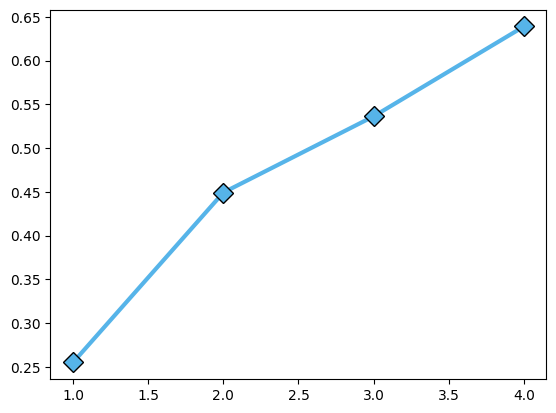

In [76]:
i = 0

plt.plot(range(1, no_kbins[i]), hsummary[0][i], color=Cs[Genes[0]], lw=3, marker=Ms[Genes[0]], ms=10, mec='k', mew=1)

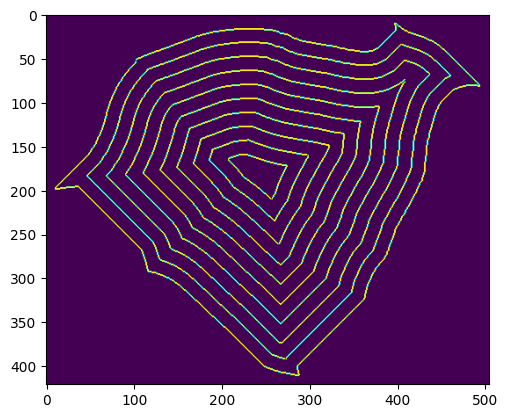

In [225]:
plt.imshow(magnitude)

In [212]:
np.unique(np.sqrt(sobel_h**2 + sobel_v**2))

array([0.        , 1.41421356, 2.        , 2.82842712, 3.16227766,
       4.        , 4.24264069, 4.47213595])

In [151]:
summary = pd.DataFrame(summary, columns=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 
                       index=range(1,len(kbins))).astype({'count':int})
summary

,count,mean,std,min,25%,50%,75%,max
1,80014,0.147944,0.070709,0.000000,0.096191,0.141035,0.193935,0.351713
2,67034,0.128926,0.067674,0.014951,0.076832,0.113943,0.168425,0.346143
3,51150,0.046118,0.031719,0.002603,0.023212,0.038568,0.060578,0.263788
4,37664,0.010719,0.007858,0.000277,0.004978,0.008590,0.014400,0.056187
5,24288,0.007620,0.005340,0.000000,0.003390,0.006875,0.011083,0.023632
6,10010,0.007095,0.006506,0.000000,0.000000,0.005968,0.011778,0.024121


In [119]:
pd.Series(hkde[:,  zoom == hlevel ].ravel()).describe().index

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')